# MNIST machine learning exercise

In this exercise we will demonstrate the use of Keras and Keras Tune to identify a feedforward neural network that best predicts the a handwritten digit. 

We use the MNIST data set;

![mnist data](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

# 1.0 Load and explore data (shouldn't need any transformations)

In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from __future__ import print_function
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn import datasets

np.random.seed(1)

Load the MNIST digits dataset. It's originally from UCI machine learning library, but included in SKLearn.

In [3]:
mnist = datasets.load_digits() # sklearn includes this data set .. https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

In [4]:
type(mnist)

sklearn.utils._bunch.Bunch

Notice that the dataset is stored in a Bunch type (see sklearn https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html)

We can view this dataset as similar to a dictionary; we can look at all the keys by doing the following:

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Note thjat there are 1797 images.

Images are 8x8 grid of values epresenting the gray level for each pixel (16 levels of grey -- from 0 (black) to 15 (white)). 

In [6]:
mnist.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

To analyze this, we simple turn this into a one dimensional array (so we will x1, x2, ... x63, x64). This has already been done for us, and is stored in the data key.

In [7]:
mnist.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

If we want the number of images, we can use the len function.

In [8]:
print(len(mnist.data))

1797


And, for each image we have a target value

In [9]:
print(len(mnist.target))

1797


To identify any issues with data imbalance, let's look at the number of observations for each digit 

In [10]:
import collections

counts = collections.Counter(mnist.target)

counts

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

We can also look at this as a barplot...

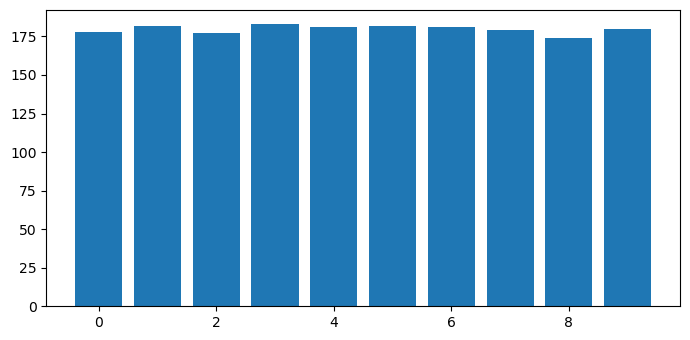

In [11]:
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot bar chart with data points
plt.bar(counts.keys(), counts.values())

# Display the plot
plt.show()

We can use matplotlib to display a sample of these images from the data.

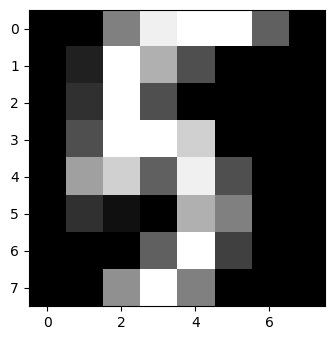

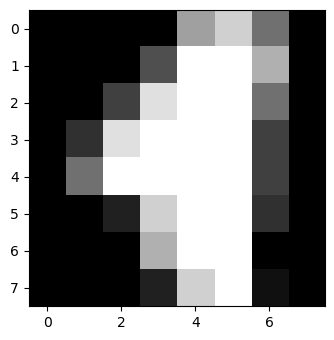

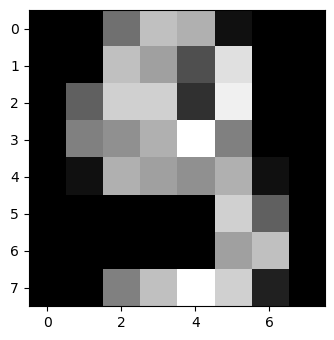

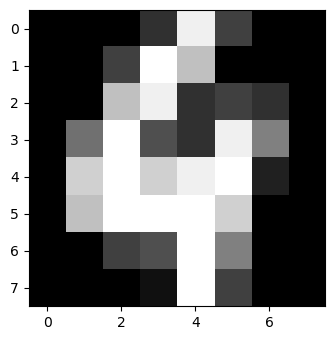

In [12]:
for i in np.random.choice(range(0,len(mnist.images)), 4): # choose 4 at random
    plt.imshow(mnist.images[i], cmap='gray')
    plt.show()

# 2.0 Model data using Keras sequential neural networks

Split data into training and test sets


In [13]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=1)

Create a unique log directory name (to store logs for later analysis using tensorboard)

In [14]:
import datetime
datestring = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

## 2.1 Keras Hyperparameter tuning

Import the libraries we will use

In [15]:
import keras_tuner
# If you don't have keras_tuner installed, run the following in your terminal (mac), or anaconda prompt (windows)
# conda install -c conda-forge keras-tuner



from tensorflow import keras
from tensorflow.keras import layers

Create a function that builds the model. This is used by random search to generate a model for each set of paramete values that keras tuner's RandomSearch function generates. 

Notice that there are a number of references to 'hp' in this function. Hp is a keras hyper parameter object that RandomSearch will send to our build_model function. The hp.Boolean, hb.Int, hp.Float methods will generate a random value based on the parameters given to each method. 

These hyperparameter randomization methods are well documented [here](https://keras.io/api/keras_tuner/hyperparameters/).
* hp.Boolean
* hp.Int
* hp.Float
* hp.Choice

The build_model function will use the random values to create a Keras sequential neural network and return it back to the calling function (RandomSearch that is calling this function)
* [Input layer](https://keras.io/api/layers/core_layers/input/)
* [Dropout layer](https://keras.io/api/layers/regularization_layers/dropout/)
* [Normalization layer](http://keras.io/api/layers/preprocessing_layers/numerical/normalization/)
* [Dense layer](https://keras.io/api/layers/core_layers/dense/)


In [16]:
import numpy as np
import tensorflow as tf
from keras import backend as K


def recall(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    y_true = K.ones_like(y_true)
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)

In [17]:
def build_model(hp):
    model = keras.Sequential()

    # create input layer
    model.add(layers.Input(64))

    dropout = hp.Boolean("dropout") # generate a boolean variable called dropout whos value is randomly set to either True of False
    normalize = hp.Boolean("normalize") # generate a boolean variable called normalize whos value is randomly set to either True of False

    # create hidden layers
    for i in range(hp.Int(name='hidden_layer_count', min_value=1, max_value=5, step=1)):
        model.add(layers.Dense(units=hp.Int("units", min_value=32, max_value=1024, step=32),activation=hp.Choice("activation", ["selu", "elu", "relu", "tanh"]))) 
        if dropout:
            model.add(layers.Dropout(rate=hp.Float("dropout rate", min_value=0.01, max_value=0.1, step=.005)))
        if normalize:
            model.add(layers.Normalization())

    model.add(layers.Dense(units=10, activation="softmax"))

    # Define the optimizer learning rate as a hyperparameter.
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")   
    choice = hp.Choice(name='optimizer', values=['adam', 'sgd'])
    if 'adam' == choice:
        optimizer = keras.optimizers.legacy.Adam(learning_rate=lr)  # for M1/M2 use optimizers.legacy.Adam, otherwise use optimizers.Adam
    else:
        optimizer = keras.optimizers.legacy.SGD(learning_rate=lr)  # for M1/M2 use optimizers.legacy.SGD, otherwise use optimizers.SGD

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        # see here https://www.tensorflow.org/api_docs/python/tf/keras/losses
        
        # Though you can add a metric, this doesn't get used to train the model, it's only informative (see previous notebook for more detail).
        metrics=['accuracy', f1, recall, precision],  # you need to set this in order for keras_tuner to have one of these objectives!
        # for metrics, see https://www.tensorflow.org/api_docs/python/tf/keras/metrics/
    )
    return model

build_model(keras_tuner.HyperParameters())

We now use our model generating function to conduct a random search to identify the best fitting model (from a random selection of the parameter ranges identified in the build_model function we created above).

NOTE: That the number of trials represents the number of unique combinations of hyperparameters that will be tested. the executions per trial are how many trials of of a model with this chosen set of parameters will be tested. So, if we have 10 trials and 3 executions, we will train 30 times... 3 times per each 10 sets of parameters.

In [18]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
# 
# You can use metrics other than accuracy, but you need to have this defined in the build model first
# For instance, if you have f1 defined in the build model, to have keras_tuner 'tune' on f1, you set objective to be 'val_f1'. 
# For precision you would have to have precision defined in the build model, and to tune on precision, you set the object to 
# be 'val_precision', etc.
# 
# Also, for custom objectives, you need to set a 'direction' for the tune... so if you want to maximize f1, you set direction to be 'max'.
# 
#    objective = keras_tuner.Objective("val_f1", direction="max"), 
  
    max_trials=150, # max_trials represents the number of hyperparameter combinations that will be tested by the tuner (like n_iter in sklearn random search)
    executions_per_trial=2, # max number of models to fit per set of set of hyperparameters combinations

    # the next three parameters about where the results from the training are stored
    directory=f'logs/{datestring:s}',
    project_name="keras_tuned",
    overwrite=True
)

Get a summary of the overal 'search space' (all the possible parmater values).

In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
dropout (Boolean)
{'default': False, 'conditions': []}
normalize (Boolean)
{'default': False, 'conditions': []}
hidden_layer_count (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'elu', 'relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


Train the model...

NOTE:


LambdaCallback is constructed with the following anonymous functions that will be called at the appropriate time.

* on_epoch_begin: called at the beginning of every epoch.
* on_epoch_end: called at the end of every epoch.
* on_batch_begin: called at the beginning of every batch.
* on_batch_end: called at the end of every batch.
* on_train_begin: called at the beginning of model training.
* on_train_end: called at the end of model training.

In [20]:
%%time
import time
from tensorflow.keras.callbacks import LambdaCallback
    
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: print(f'Starting Epoch {epoch+1}!')
)

batch_loss_callback = LambdaCallback(
    on_batch_end=lambda batch,logs: print(f'\n After batch {batch}, the loss is {logs}.')
)
    
train_finish_callback = LambdaCallback(
    on_train_end=lambda logs: print('Training finished!')
)

tuner.search(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=200, 
    validation_data=(X_test, y_test), 
    callbacks=[epoch_callback, batch_loss_callback, train_finish_callback]
)

Trial 150 Complete [00h 00m 05s]
val_accuracy: 0.9444444477558136

Best val_accuracy So Far: 0.9902777671813965
Total elapsed time: 00h 07m 20s
INFO:tensorflow:Oracle triggered exit
CPU times: user 11min 30s, sys: 2min 57s, total: 14min 27s
Wall time: 7min 19s


In [21]:
tuner.results_summary()

Results summary
Results in logs/2023-04-11-15-15-31/keras_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 135 summary
Hyperparameters:
dropout: False
normalize: True
hidden_layer_count: 3
units: 416
activation: relu
lr: 0.00206871879825104
optimizer: adam
dropout rate: 0.08499999999999999
Score: 0.9902777671813965

Trial 035 summary
Hyperparameters:
dropout: True
normalize: True
hidden_layer_count: 5
units: 640
activation: tanh
lr: 0.00040883160006855156
optimizer: adam
dropout rate: 0.060000000000000005
Score: 0.9888888597488403

Trial 109 summary
Hyperparameters:
dropout: False
normalize: False
hidden_layer_count: 4
units: 544
activation: tanh
lr: 0.0017111689990377582
optimizer: adam
dropout rate: 0.075
Score: 0.9888888597488403

Trial 140 summary
Hyperparameters:
dropout: False
normalize: False
hidden_layer_count: 2
units: 704
activation: relu
lr: 0.0007588323663982013
optimizer: adam
dropout rate: 0.09
Score: 0.987500011920929

Trial 048 summary

In [22]:
best_hps = tuner.get_best_hyperparameters(5)
best_hps[0].values

{'dropout': False,
 'normalize': True,
 'hidden_layer_count': 3,
 'units': 416,
 'activation': 'relu',
 'lr': 0.00206871879825104,
 'optimizer': 'adam',
 'dropout rate': 0.08499999999999999}

Let's get an overview of the structure of the top model (set of parameters) found.

In [23]:
# Get list of the top 2 models.
models = tuner.get_best_models(num_models=2)
# select the first one in the list (this is the best performing model)
best_model = models[0] # select the first one
# display summary of model training
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               27040     
                                                                 
 normalization (Normalizatio  (None, 416)              833       
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 normalization_1 (Normalizat  (None, 416)              833       
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 416)               173472    
                                                                 
 normalization_2 (Normalizat  (None, 416)              8

In [24]:
(loss,accuracy,f1_score, precision, recall) = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss} Accuracy: {accuracy} F1 Score: {f1_score} Precision: {precision} Recall: {recall}")

12/12 [==============================] - 0s 2ms/step - loss: 0.0575 - accuracy: 0.9917 - f1: 0.9987 - recall: 0.9974 - precision: 1.0000
Loss: 0.05750808119773865 Accuracy: 0.9916666746139526 F1 Score: 0.9986772537231445 Precision: 0.9973958134651184 Recall: 1.0


Let's look at the confusion matrix....

[(0, 43), (1, 35), (2, 36), (3, 41), (4, 38), (5, 30), (6, 37), (7, 37), (8, 29), (9, 34)]
12/12 [==============================] - 0s 2ms/step


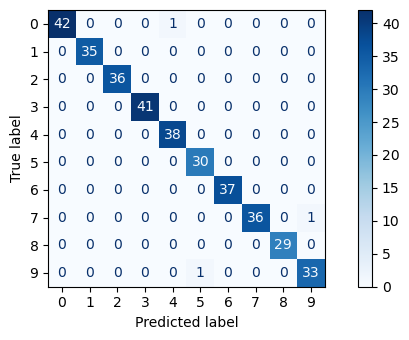

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# for reference, list the frequency of each digit found in the y_test data
print(sorted(collections.Counter(y_test).items(), key=lambda i: i[0]))
      
# display the confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()